# Wells Fargo Challenge

- https://www.mindsumo.com/contests/campus-analytics-challenge-2021

### To Complete a Submission:

Build a classification model for predicting elder fraud in the digital payments space as described in Rule 4, which:

- Handles missing variables
- Maximizes the F1 score
- Uses the given data set
- Includes suitable encoding schemes
- Has the least set of feature variables

### Resources
- https://github.com/pdglenn/WellsFargoAnalyticsChallenge

In [1]:
import pandas as pd
import numpy as np
import pylab as plt
import seaborn as sns

data_dir = "./dataset/"

# following few lines are to supress the pandas warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

pd.options.mode.chained_assignment = None 
pd.options.display.max_columns = 20
np.set_printoptions(suppress=True) 

data_dir = "./dataset/"
image_dir = "./images/"


## Loading the data

In [2]:
# load the file
df_orig = pd.read_excel(data_dir+"trainset.xlsx", engine='openpyxl')
df_orig.head(2)

,TRAN_AMT,ACCT_PRE_TRAN_AVAIL_BAL,CUST_AGE,OPEN_ACCT_CT,WF_dvc_age,PWD_UPDT_TS,CARR_NAME,RGN_NAME,STATE_PRVNC_TXT,ALERT_TRGR_CD,...,CUST_STATE,PH_NUM_UPDT_TS,CUST_SINCE_DT,TRAN_TS,TRAN_DT,ACTN_CD,ACTN_INTNL_TXT,TRAN_TYPE_CD,ACTVY_DT,FRAUD_NONFRAUD
0,5.38,23619.91,47,4,2777,1/16/2018 11:3:58,cox communications inc.,southwest,nevada,MOBL,...,NV,2/24/2021 15:55:10,1993-01-06,5/3/2021 18:3:58,5/3/2021,SCHPMT,P2P_COMMIT,P2P,5/3/2021,Non-Fraud
1,65.19,0.00,45,5,2721,NaN,charter communications,southwest,california,MOBL,...,CA,NaN,1971-01-07,1/13/2021 19:19:37,1/13/2021,SCHPMT,P2P_COMMIT,P2P,1/13/2021,Non-Fraud


## Train test split

Before doing any data visualization let's set some test data aside and use them to score the model later on.

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# stratify the target column so that the distribution look similar in the train and test data
df_train0, df_test0 = train_test_split(df_orig,
                               test_size = .2,
                               random_state = 8848,
                               shuffle = True,
                               stratify = df_orig["FRAUD_NONFRAUD"])

## Feature Engineering, Transformation and Data Imputation

- In cases where the PWD_update and PH_NUM_update are after the transaction date we risk using the future information to make a predictive modeling. This on one hand might improve the model performance for the training/test data but it has a risk of 

In [8]:
def convert_future_info_to_past(df, tran_date, pwd_phn_date, cust_since_date ):
    # for cases where transaction date is after pwd_update/phone_num_update date
    # then we'd get a -ve value
    # so replace the -ve values by tran_date - cust_since_date
    return np.where((df[tran_date]-df[pwd_phn_date]).dt.days <0,
                    (df[tran_date]- df[cust_since_date]).dt.days, 
                    (df[tran_date]-df[pwd_phn_date]).dt.days)

In [9]:
def convert_date_format(x):
    if len(str(x).split("/"))>1:
        m,d,y=str(x).strip().split()[0].split("/")
        if d=='0':
            d='1'
        elif d=='31':
            d='30'
        return "-".join([y,m,d])
    else:
        return str(x).split()[0]

def feature_engineering(df):
    # conver the _DT columns to pandas datetime
    cols_DT = [c for c in df.columns if "_DT" in c]
    df[cols_DT] = df[cols_DT].apply(pd.to_datetime)
    # convert the TRAN_Timestamp to only hour
    df["TRAN_HOUR"]=pd.to_datetime(df['TRAN_TS']).dt.strftime("%H")
    # Fill the Nulls for Phone update by the cust_since_date and keep only date
    df["PH_NUM_UPDT_DT"]=pd.to_datetime(df["PH_NUM_UPDT_TS"].fillna(df["CUST_SINCE_DT"]).apply(convert_date_format))
    # Fill the Nulls for pwd update by the cust_since_date and keep only date
    df["PWD_UPDT_DT"]=pd.to_datetime(df["PWD_UPDT_TS"].fillna(df["CUST_SINCE_DT"]).apply(convert_date_format))
    # Num of days between TRAN_DATE and PWD_UPDATE_DAYS
    df["PWD_UPDT_DAYS"] = convert_future_info_to_past(df, "TRAN_DT",
                                                      "PWD_UPDT_DT",
                                                      "CUST_SINCE_DT")
    
    
    #np.where( (df["TRAN_DT"]-df["PWD_UPDT_DT"]).dt.days <0,
    #                               (df["TRAN_DT"]- df["CUST_SINCE_DT"]).dt.days, 
    #                               (df["TRAN_DT"]-df["PWD_UPDT_DT"]).dt.days
    #                              )
    
    # Num of days between TRAN_DATE and PHONE_NUM_UPDATE_DAYS
    df["PH_NUM_UPDT_DAYS"] = convert_future_info_to_past(df, "TRAN_DT",
                                                         "PH_NUM_UPDT_DT",
                                                         "CUST_SINCE_DT")
    
    #np.where( (df["TRAN_DT"]-df["PH_NUM_UPDT_DT"]).dt.days <0,
    #                                  (df["TRAN_DT"]- df["CUST_SINCE_DT"]).dt.days,
    #                                  (df["TRAN_DT"]-df["PH_NUM_UPDT_DT"]).dt.days
    #                                 )
    
    # Num of days between TRAN_DATE and CUST_SINCE_DATE
    #df["TRAN_DAYS"] = (df["TRAN_DT"] - df["CUST_SINCE_DT"]).dt.days
    # Num of days between PWD update and phone number update
    #df["PH_NUM_PWD_DAYS"]=df["PH_NUM_UPDT_DAYS"] - df["PWD_UPDT_DAYS"]
    df["RAND"] =np.random.rand(df.shape[0])
    return df

In [10]:
def get_imputation_values(df):
    
    # find numerical and categorical columns
    nume_cols = list(df.select_dtypes(include="number").columns)
    cate_cols = list(df.select_dtypes(exclude="number").columns)
    nume_cols.remove('CUST_ZIP')
    cate_cols.append('CUST_ZIP')
    nume_cols.remove('FRAUD_NONFRAUD')
   
    impute_vals={}

    for col in df.columns:
        if col in nume_cols:
            impute_vals[col] = df[col].median()
        elif col in cate_cols:
            impute_vals[col] = df[col].mode()[0]
    return nume_cols, cate_cols, impute_vals

In [11]:
def impute_data(df, impute_dict):
    """
    this function takes in a dataframe and list of columns which have missing values
    then imputes those columns using the precomputed values.
    """
    for col in list(impute_dict.keys()):
        df[col] = df[col].fillna(impute_dict[col])
    return df

In [12]:
def transform_cate_data(df):
    #CUST_STATE
    # keep only CO, TX, MN, AZ and convert rest into OTHER
    df["CUST_STATE"] = df["CUST_STATE"].apply(lambda x: x if x in ["CO", "TX", "MN", "AZ"] else "OTHER")
    #OPEN_ACCT_CT
    #keep only the [2,9] and convert others to 10
    df["OPEN_ACCT_CT"] = df["OPEN_ACCT_CT"].apply(lambda x: x if x in range(1,13) else 13)
    return df

## Modelling

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, roc_auc_score, plot_roc_curve

In [14]:
class Model_training:
    def __init__(self, model, X_train, y_train, X_test, y_test, savename="Fig"):
        self.model = model
        self.X_train = X_train
        self.y_train = y_train
        self.X_test  = X_test
        self.y_test  = y_test
        self.savename = savename
        self.model.fit(self.X_train, self.y_train)
        
    def print_metrics(self):
        round_to_pct = lambda x: np.round(100*x, 2)
        y_pred = self.model.predict(self.X_test)
        ac = round_to_pct(accuracy_score(self.y_test, y_pred))
        f1 = round_to_pct(f1_score(self.y_test, y_pred))
        pr = round_to_pct(precision_score(self.y_test, y_pred))
        re = round_to_pct(recall_score(self.y_test, y_pred))
        print (f"Accuracy = {ac}% F1 Score= {f1}% \nPrecision={pr}% Recall= {re}%")
        print (classification_report(self.y_test, y_pred))
        return (self.model, (ac, f1, pr, re))
        
    def displot(self):
        pr=self.model.predict_proba(self.X_test)        
        roc_auc = np.round(roc_auc_score(self.y_test,
                                         self.model.predict_proba(self.X_test)[:, 1]), 2)

        pr_df = pd.DataFrame({'pred_0':pr[:,0], 
                              'pred_1':pr[:,1], 
                              'y': self.y_test})

        ax=sns.displot(data=pr_df, 
                       x='pred_1', 
                       hue='y', 
                       alpha=0.8, 
                       kind="kde",
                       height = 3.5, 
                       aspect=1.8);
        
        plt.xlabel("Prob. Positive Predictions", fontsize=16)
        plt.text(0.2, 2, "ROC_AUC="+str(roc_auc), fontsize=16)
        plt.ylabel("Density", fontsize=16)
        
        plt.yticks(fontsize=16);
        plt.xticks(fontsize=16);
        figname = "images/displot_"+self.savename+".png"
        plt.savefig(figname, dpi=300, bbox_inches='tight')

    def feature_importance(self):
        # find the feature importance for both single model 
        # or a grid search cv model
        try:
            imp = self.model.feature_importances_
        except:
            imp = self.model.best_estimator_.feature_importances_

        df_imp = pd.DataFrame({"Feature":self.X_train.columns, 
                               "Feature Importance":imp})
        
        df_imp = df_imp.sort_values(by=['Feature Importance'],
                                    axis=0,
                                    ascending=True)
        
        df_imp.plot(kind='barh',
                    x='Feature', 
                    y='Feature Importance',
                    color="C2", figsize=(8,5));
        
        plt.grid(axis='x')
        plt.yticks(fontsize=16);
        plt.ylabel('');
        plt.xticks(fontsize=16);
        plt.legend(loc='best',fontsize=16);
        
        figname = "images/feat_imp_"+self.savename+".png"
        plt.savefig(figname, dpi=300, bbox_inches='tight')
        
    def plot_roc_curve(self):
        roc_auc = np.round(roc_auc_score(self.y_test,
                                         self.model.predict_proba(self.X_test)[:, 1]), 2)
        label_name = self.savename +"\nAUC = "+str(roc_auc)
        
        plot_roc_curve(self.model, self.X_test, self.y_test,
                       lw=3., color='C2', label=label_name)
        plt.title("ROC Curve", fontsize=18)
        plt.xlabel("False Positive Rate", fontsize=16)
        plt.ylabel("True Positive Rate", fontsize=16)
        plt.xticks(fontsize=16);
        plt.yticks(fontsize=16);
        plt.legend(loc="center", fontsize=14);
        plt.axvline(x=0, color='k', ls='--', lw=1)
        plt.axhline(y=0, color='k', ls='--', lw=1)
        plt.axhline(y=1, color='k', ls='--', lw=1)
        
        figname = "images/roc_curve_"+self.savename+".png"
        plt.savefig(figname, dpi=300, bbox_inches='tight')

## Modeling 1: Numerical features (Given only)

In [15]:
df1 = df_train0.copy()
df1["FRAUD_NONFRAUD"] =  df1["FRAUD_NONFRAUD"].map({"Fraud":1, "Non-Fraud":0})
df1 = feature_engineering(df1)
nume_cols, cate_cols, impute_vals = get_imputation_values(df1)
df1 = impute_data(df1, impute_vals)
df1 = transform_cate_data(df1)

In [16]:
df1.head(2)

,TRAN_AMT,ACCT_PRE_TRAN_AVAIL_BAL,CUST_AGE,OPEN_ACCT_CT,WF_dvc_age,PWD_UPDT_TS,CARR_NAME,RGN_NAME,STATE_PRVNC_TXT,ALERT_TRGR_CD,...,ACTN_INTNL_TXT,TRAN_TYPE_CD,ACTVY_DT,FRAUD_NONFRAUD,TRAN_HOUR,PH_NUM_UPDT_DT,PWD_UPDT_DT,PWD_UPDT_DAYS,PH_NUM_UPDT_DAYS,RAND
2413,487.93,3714.91,43,5,1037,5/18/2020 4:7:20,cox communications inc.,southwest,california,MOBL,...,P2P_COMMIT,P2P,2021-04-13,1,05,2020-05-01,1988-01-11,12146,347,0.460796
1003,4.84,0.00,53,5,305,4/12/2017 15:54:53,cox communications inc.,southwest,california,MOBL,...,P2P_COMMIT,P2P,2021-04-29,0,22,1987-04-05,2017-04-12,1478,12443,0.797658


In [15]:
df1_te = df_test0.copy()
df1_te["FRAUD_NONFRAUD"] =  df1_te["FRAUD_NONFRAUD"].map({"Fraud":1, "Non-Fraud":0})
df1_te = feature_engineering(df1_te)
df1_te = impute_data(df1_te, impute_dict=impute_vals)
df1_te = transform_cate_data(df1_te)

In [16]:
nume_cols1 = list(df_train0.select_dtypes(include="number").columns)
nume_cols1.remove('CUST_ZIP')   
nume_cols1

['TRAN_AMT',
 'ACCT_PRE_TRAN_AVAIL_BAL',
 'CUST_AGE',
 'OPEN_ACCT_CT',
 'WF_dvc_age']

In [35]:
X_train1, y_train1 = df1[nume_cols1], df1["FRAUD_NONFRAUD"]
X_test1,  y_test1  = df1_te[nume_cols1], df1_te["FRAUD_NONFRAUD"]
X_train1.shape, y_train1.shape, X_test1.shape, y_test1.shape

((11200, 5), (11200,), (2800, 5), (2800,))

In [50]:
X_train1.head(2)

,TRAN_AMT,ACCT_PRE_TRAN_AVAIL_BAL,CUST_AGE,OPEN_ACCT_CT,WF_dvc_age
2413,487.93,3714.91,43,5,1037
1003,4.84,0.00,53,5,305


Accuracy = 92.82% F1 Score= 87.41% 
Precision=91.36% Recall= 83.79%
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1967
           1       0.91      0.84      0.87       833

    accuracy                           0.93      2800
   macro avg       0.92      0.90      0.91      2800
weighted avg       0.93      0.93      0.93      2800



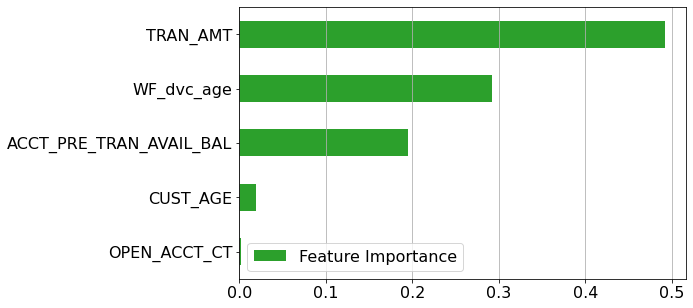

In [37]:
rf = RandomForestClassifier(max_depth=2)
mod = Model_training(rf,
                     X_train1, y_train1, X_test1, y_test1,
                     "tmp")

mod_tr, _= mod.print_metrics()
mod.feature_importance()

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.8s finished


Accuracy = 93.32% F1 Score= 88.28% 
Precision=92.39% Recall= 84.51%
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      1967
           1       0.92      0.85      0.88       833

    accuracy                           0.93      2800
   macro avg       0.93      0.91      0.92      2800
weighted avg       0.93      0.93      0.93      2800

Best parameters: {'max_depth': 3}


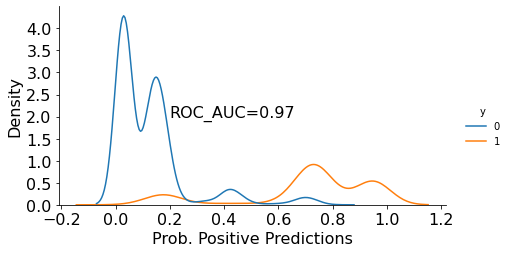

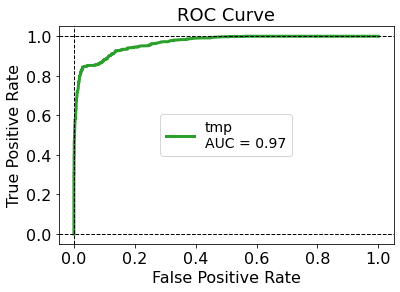

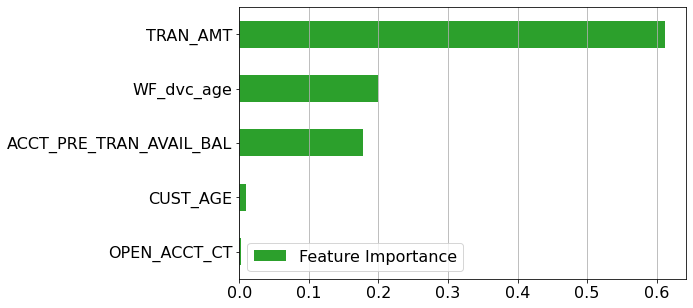

In [38]:
model_rf_gs = GridSearchCV(RandomForestClassifier(),
                           param_grid={'max_depth':[2,3]},
                           scoring ='f1',
                           verbose=1)

mod = Model_training(model_rf_gs,
                     X_train1, y_train1, X_test1, y_test1,
                     "tmp")
mod_tr, _= mod.print_metrics()
print ("Best parameters:", mod_tr.best_params_)
mod.displot()
mod.plot_roc_curve()
mod.feature_importance()

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   25.9s finished


Accuracy = 93.5% F1 Score= 88.58% 
Precision=92.77% Recall= 84.75%
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      1967
           1       0.93      0.85      0.89       833

    accuracy                           0.94      2800
   macro avg       0.93      0.91      0.92      2800
weighted avg       0.93      0.94      0.93      2800

Best parameters: {'max_depth': 13}


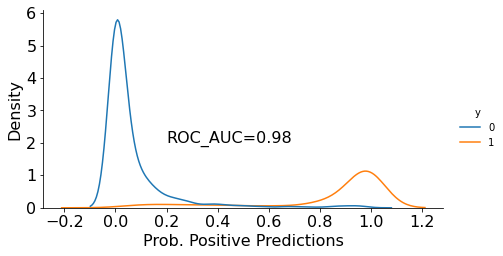

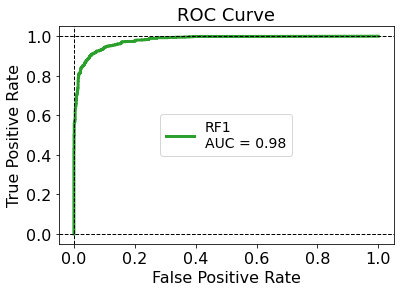

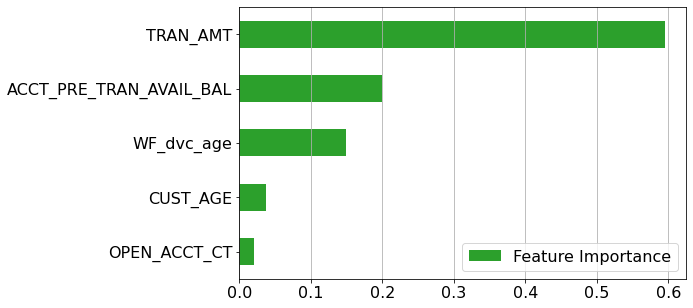

In [15]:
model_rf_gs = GridSearchCV(RandomForestClassifier(),
                           param_grid={'max_depth':[12, 13, 14, 15, 16, 17]},
                           scoring ='f1',
                           verbose=1)

mod = Model_training(model_rf_gs,
                     X_train1, y_train1, X_test1, y_test1,
                     "RF1")
mod_tr, _= mod.print_metrics()
print ("Best parameters:", mod_tr.best_params_)
mod.displot()
mod.plot_roc_curve()
mod.feature_importance()

Accuracy = 92.93% F1 Score= 87.78% 
Precision=90.34% Recall= 85.35%
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1967
           1       0.90      0.85      0.88       833

    accuracy                           0.93      2800
   macro avg       0.92      0.91      0.91      2800
weighted avg       0.93      0.93      0.93      2800

Best parameters: {'eval_metric': 'logloss', 'max_depth': 11, 'reg_alpha': 0.1}


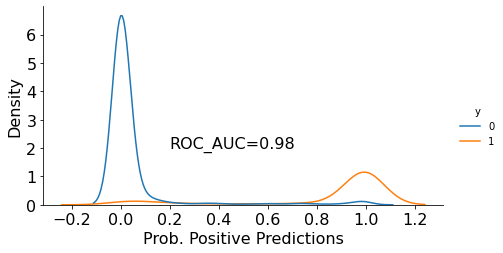

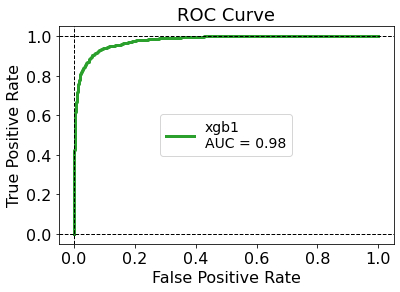

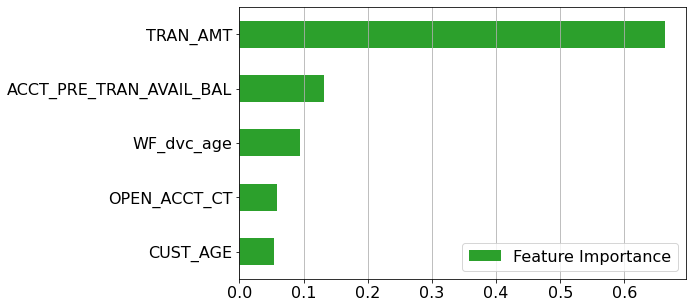

In [16]:
xgb_gs = GridSearchCV(XGBClassifier(),
                      param_grid={'max_depth':[10, 11, 12, 13, 14],
                                  'eval_metric' :["logloss"],
                                  'reg_alpha':[0.1, 0.5]},
                      scoring = 'f1',
                      verbose = 0)

mod = Model_training(xgb_gs, X_train1, y_train1, X_test1, y_test1, "xgb1")
mod_tr, _= mod.print_metrics()
print ("Best parameters:", mod_tr.best_params_)
mod.displot()
mod.plot_roc_curve()
mod.feature_importance()

## Modeling 2: Numerical features (Given + Engineered)

In [17]:
X_train2, y_train2 = df1[nume_cols], df1["FRAUD_NONFRAUD"]
X_test2,  y_test2  = df1_te[nume_cols], df1_te["FRAUD_NONFRAUD"]
X_train2.shape, y_train2.shape, X_test2.shape, y_test2.shape

((11200, 8), (11200,), (2800, 8), (2800,))

In [22]:
nume_cols.remove("RAND")

In [24]:
X_train3, y_train3 = df1[nume_cols], df1["FRAUD_NONFRAUD"]
X_test3,  y_test3  = df1_te[nume_cols], df1_te["FRAUD_NONFRAUD"]
X_train3.shape, y_train3.shape, X_test3.shape, y_test3.shape

((11200, 7), (11200,), (2800, 7), (2800,))

In [28]:
nume_cols

['TRAN_AMT',
 'ACCT_PRE_TRAN_AVAIL_BAL',
 'CUST_AGE',
 'OPEN_ACCT_CT',
 'WF_dvc_age',
 'PWD_UPDT_DAYS',
 'PH_NUM_UPDT_DAYS']

In [29]:
nume_cols2= ['TRAN_AMT', 'ACCT_PRE_TRAN_AVAIL_BAL',
             'WF_dvc_age', 'PWD_UPDT_DAYS', 'PH_NUM_UPDT_DAYS']

In [30]:
X_train4, y_train4 = df1[nume_cols2], df1["FRAUD_NONFRAUD"]
X_test4,  y_test4  = df1_te[nume_cols2], df1_te["FRAUD_NONFRAUD"]
X_train4.shape, y_train4.shape, X_test4.shape, y_test4.shape

((11200, 5), (11200,), (2800, 5), (2800,))

In [25]:
X_train3.head(2)

,TRAN_AMT,ACCT_PRE_TRAN_AVAIL_BAL,CUST_AGE,OPEN_ACCT_CT,WF_dvc_age,PWD_UPDT_DAYS,PH_NUM_UPDT_DAYS
2413,487.93,3714.91,43,5,1037,12146,347
1003,4.84,0.00,53,5,305,1478,12443


In [26]:
X_test3.head(2)

,TRAN_AMT,ACCT_PRE_TRAN_AVAIL_BAL,CUST_AGE,OPEN_ACCT_CT,WF_dvc_age,PWD_UPDT_DAYS,PH_NUM_UPDT_DAYS
3032,494.73,2542.73,71,3,248,1647,1647
4838,489.42,3324.74,46,3,0,255,554


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   34.4s finished


Accuracy = 93.86% F1 Score= 89.29% 
Precision=92.76% Recall= 86.07%
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      1967
           1       0.93      0.86      0.89       833

    accuracy                           0.94      2800
   macro avg       0.94      0.92      0.92      2800
weighted avg       0.94      0.94      0.94      2800

Grid Search Best Parameters {'max_depth': 16}


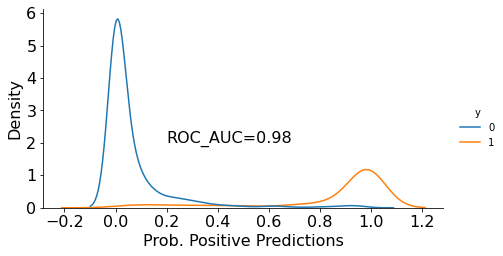

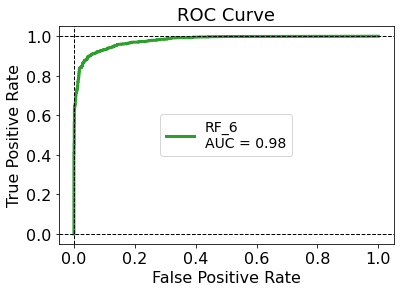

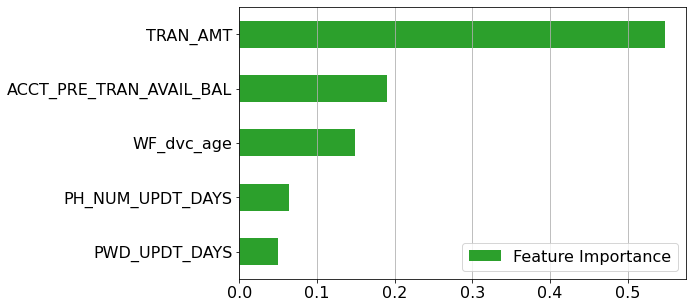

In [31]:
model_rf_gs = GridSearchCV(RandomForestClassifier(),
                           param_grid={'max_depth':[12, 13, 14, 15, 16, 17]},
                           scoring ='f1',
                           verbose=1)

mod = Model_training(model_rf_gs,
                     X_train4, y_train4, X_test4, y_test4,
                     "RF_6")
mod_tr, _= mod.print_metrics()
print ("Grid Search Best Parameters", mod_tr.best_params_)
mod.displot()
mod.plot_roc_curve()
mod.feature_importance()

In [32]:
mod.model.best_score_

0.8998852409654472

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   33.4s finished


Accuracy = 93.82% F1 Score= 89.23% 
Precision=92.64% Recall= 86.07%
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      1967
           1       0.93      0.86      0.89       833

    accuracy                           0.94      2800
   macro avg       0.93      0.92      0.92      2800
weighted avg       0.94      0.94      0.94      2800

Grid Search Best Parameters {'max_depth': 17}


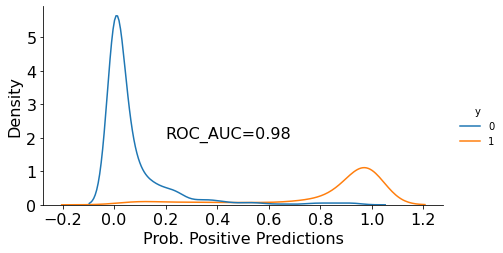

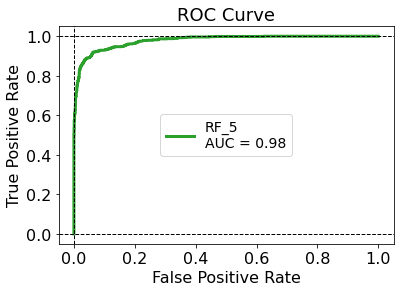

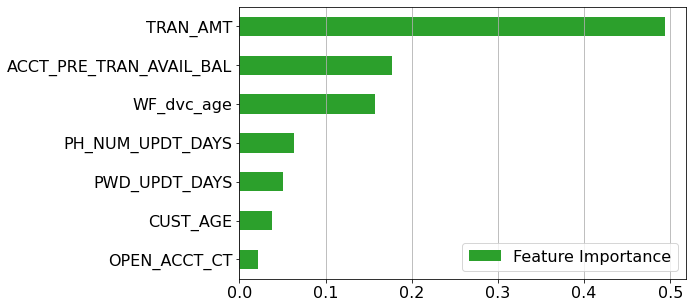

In [27]:
model_rf_gs = GridSearchCV(RandomForestClassifier(),
                           param_grid={'max_depth':[12, 13, 14, 15, 16, 17]},
                           scoring ='f1',
                           verbose=1)

mod = Model_training(model_rf_gs,
                     X_train3, y_train3, X_test3, y_test3,
                     "RF_5")
mod_tr, _= mod.print_metrics()
print ("Grid Search Best Parameters", mod_tr.best_params_)
mod.displot()
mod.plot_roc_curve()
mod.feature_importance()

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   33.7s finished


Accuracy = 93.61% F1 Score= 88.82% 
Precision=92.58% Recall= 85.35%
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      1967
           1       0.93      0.85      0.89       833

    accuracy                           0.94      2800
   macro avg       0.93      0.91      0.92      2800
weighted avg       0.94      0.94      0.94      2800

Grid Search Best Parameters {'max_depth': 17}


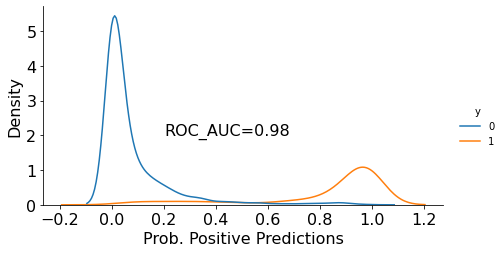

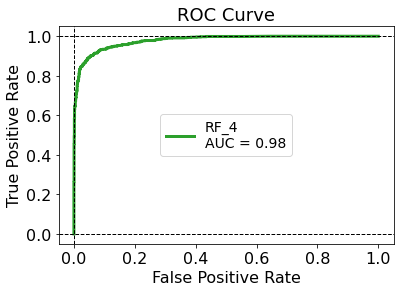

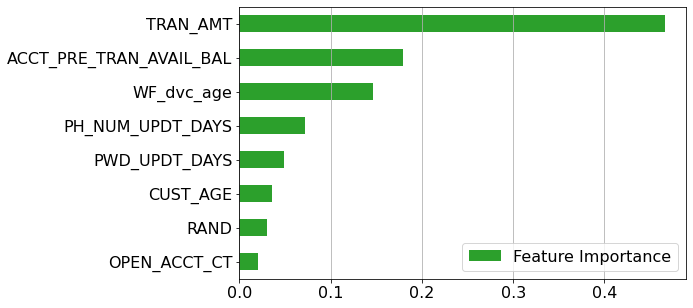

In [20]:
model_rf_gs = GridSearchCV(RandomForestClassifier(),
                           param_grid={'max_depth':[12, 13, 14, 15, 16, 17]},
                           scoring ='f1',
                           verbose=1)

mod = Model_training(model_rf_gs,
                      X_train2, y_train2, X_test2, y_test2,
                      "RF_4")
mod_tr, _= mod.print_metrics()
print ("Grid Search Best Parameters", mod_tr.best_params_)
mod.displot()
mod.plot_roc_curve()
mod.feature_importance()

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   41.2s finished


Accuracy = 94.46% F1 Score= 90.43% 
Precision=93.13% Recall= 87.88%
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1967
           1       0.93      0.88      0.90       833

    accuracy                           0.94      2800
   macro avg       0.94      0.93      0.93      2800
weighted avg       0.94      0.94      0.94      2800

Grid Search Best Parameters {'max_depth': 17}


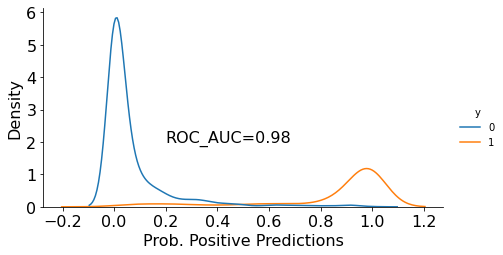

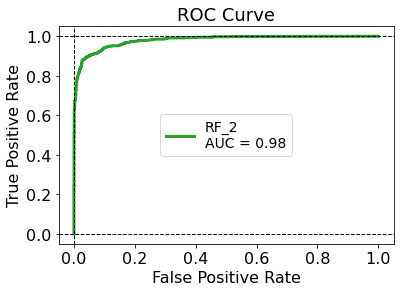

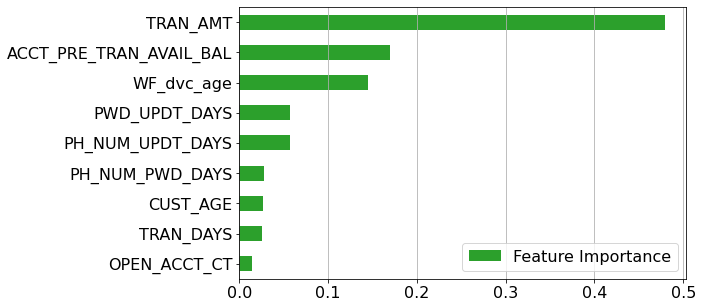

In [18]:
model_rf_gs = GridSearchCV(RandomForestClassifier(),
                           param_grid={'max_depth':[12, 13, 14, 15, 16, 17]},
                           scoring ='f1',
                           verbose=1)

mod = Model_training(model_rf_gs,
                      X_train2, y_train2, X_test2, y_test2,
                      "RF_2")
mod_tr, _= mod.print_metrics()
print ("Grid Search Best Parameters", mod_tr.best_params_)
mod.displot()
mod.plot_roc_curve()
mod.feature_importance()

Accuracy = 93.82% F1 Score= 89.33% 
Precision=91.88% Recall= 86.91%
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1967
           1       0.92      0.87      0.89       833

    accuracy                           0.94      2800
   macro avg       0.93      0.92      0.92      2800
weighted avg       0.94      0.94      0.94      2800

Best parameters: {'eval_metric': 'logloss', 'max_depth': 12, 'reg_alpha': 0.5}


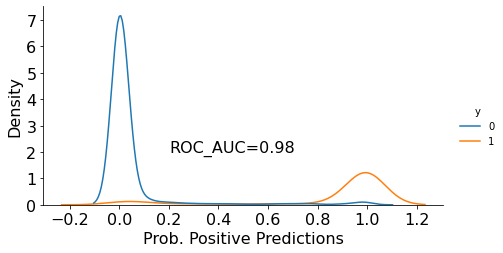

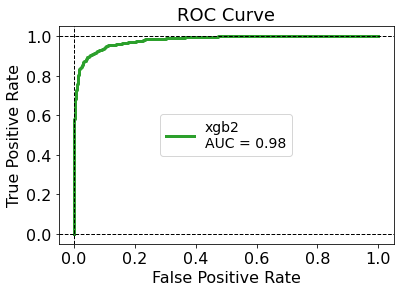

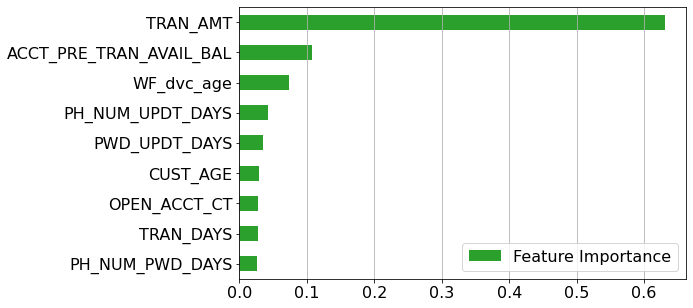

In [58]:
xgb_gs = GridSearchCV(XGBClassifier(),
                      param_grid={'max_depth':[8, 9, 10, 11, 12, 13, 14],
                                  'eval_metric' :["logloss"],
                                  'reg_alpha':[0.1, 0.5]},
                      scoring = 'f1',
                      verbose = 0)

mod = Model_training(xgb_gs, X_train2, y_train2, X_test2, y_test2, "xgb2")
mod_tr, _= mod.print_metrics()
print ("Best parameters:", mod_tr.best_params_)
mod.displot()
mod.plot_roc_curve()
mod.feature_importance()

Accuracy = 94.14% F1 Score= 89.9% 
Precision=92.29% Recall= 87.64%
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1967
           1       0.92      0.88      0.90       833

    accuracy                           0.94      2800
   macro avg       0.94      0.92      0.93      2800
weighted avg       0.94      0.94      0.94      2800

Best parameters: {'eval_metric': 'logloss', 'max_depth': 8, 'reg_alpha': 0.5}


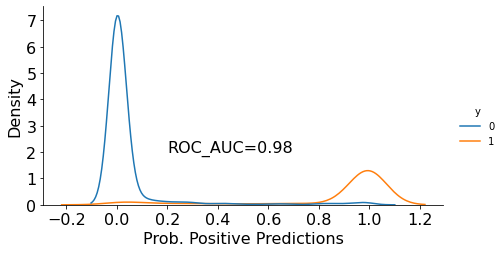

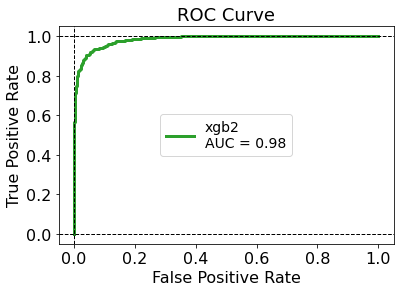

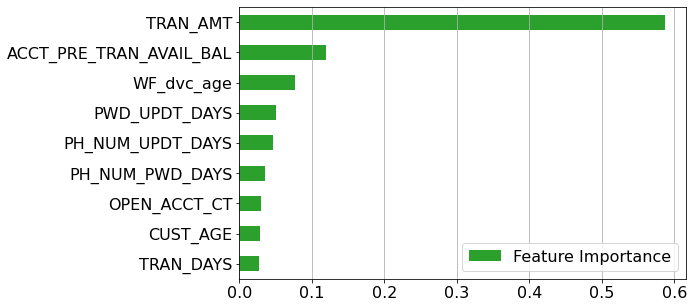

In [20]:
xgb_gs = GridSearchCV(XGBClassifier(),
                      param_grid={'max_depth':[8, 9, 10, 11, 12, 13, 14],
                                  'eval_metric' :["logloss"],
                                  'reg_alpha':[0.1, 0.5]},
                      scoring = 'f1',
                      verbose = 0)

mod = Model_training(xgb_gs, X_train2, y_train2, X_test2, y_test2, "xgb2")
mod_tr, _= mod.print_metrics()
print ("Best parameters:", mod_tr.best_params_)
mod.displot()
mod.plot_roc_curve()
mod.feature_importance()

## Modeling 3: Numerical + Categorical features

In [21]:
import category_encoders as ce

In [35]:
df1.head(2)

,TRAN_AMT,ACCT_PRE_TRAN_AVAIL_BAL,CUST_AGE,OPEN_ACCT_CT,WF_dvc_age,PWD_UPDT_TS,CARR_NAME,RGN_NAME,STATE_PRVNC_TXT,ALERT_TRGR_CD,...,TRAN_TYPE_CD,ACTVY_DT,FRAUD_NONFRAUD,TRAN_HOUR,PH_NUM_UPDT_DT,PWD_UPDT_DT,PWD_UPDT_DAYS,PH_NUM_UPDT_DAYS,TRAN_DAYS,PH_NUM_PWD_DAYS
2413,487.93,3714.91,43,5,1037,5/18/2020 4:7:20,cox communications inc.,southwest,california,MOBL,...,P2P,2021-04-13,1,05,2020-05-01,1988-01-11,12146.0,347.0,12146.0,-11799.0
1003,4.84,0.00,53,5,305,4/12/2017 15:54:53,cox communications inc.,southwest,california,MOBL,...,P2P,2021-04-29,0,22,1987-04-05,2017-04-12,1478.0,12443.0,12443.0,10965.0


In [ ]:
df2 = df_train0.copy()
df2["FRAUD_NONFRAUD"] =  df2["FRAUD_NONFRAUD"].map({"Fraud":1, "Non-Fraud":0})
df2 = impute_data(df2)
df2 = wrangle_column_data(df2)

In [ ]:
cate_cols_to_keep = ['ALERT_TRGR_CD', "CUST_STATE"]

In [ ]:
encoder = ce.OneHotEncoder()
df2_tr_cat = encoder.fit_transform(df2[cate_cols_to_keep])
df2_tr_join = pd.concat( [df2[nume_cols], df2_tr_cat], axis=1)
X_train2 = df2_tr_join
y_train2 = df2["FRAUD_NONFRAUD"]

In [ ]:
# test data
df2_te = df_test0.copy()
df2_te["FRAUD_NONFRAUD"] = df2_te["FRAUD_NONFRAUD"].map({"Fraud":1, "Non-Fraud":0})
df2_te = impute_data(df2_te)
df2_te = wrangle_column_data(df2_te)

In [ ]:
df2_te_cat = encoder.transform(df2_te[cate_cols_to_keep])
df2_te_join = pd.concat( [df2_te[nume_cols], df2_te_cat], axis=1)
X_test2 = df2_te_join
y_test2 = df2_te["FRAUD_NONFRAUD"]

In [ ]:
X_train2.shape, y_train2.shape, X_test2.shape, y_test2.shape

In [ ]:
xgb = XGBClassifier(verbosity=1,
                    max_depth=10,
                    eval_metric = "logloss")

mod6 = Model_training(xgb, X_train2, y_train2, X_test2, y_test2, "XGBoost2")
mod_trained, _ = mod5.print_metrics()
mod6.displot()
mod6.plot_roc_curve()
mod6.feature_importance()

In [ ]:
model_rf_gs = GridSearchCV(RandomForestClassifier(),
                           param_grid={'max_depth':[10, 11, 12, 13, 14, 15]},
                           scoring ='f1',
                           verbose=1)

mod7 = Model_training(model_rf_gs,
                      X_train2, y_train2, X_test2, y_test2,
                      "Random_Forest_grid_search")

mod_tr, _= mod7.print_metrics()
mod7.displot()
mod7.plot_roc_curve()

In [ ]:
mod_tr.best_params_

remove ALERT_TRGR_CD from features

In [ ]:
X_train2.head(1)

In [ ]:
cols = [c for c in list(X_train2.columns) if c not in ["ALERT_TRGR_CD_1","ALERT_TRGR_CD_2"]]
cols

In [ ]:
X_train3 = X_train2[cols]
X_test3  = X_test2[cols]
y_train3 = y_train2
y_test3  = y_test2

In [ ]:
model_rf_gs = GridSearchCV(RandomForestClassifier(),
                           param_grid={'max_depth':[11, 12, 13, 14, 15]},
                           scoring ='f1',
                           verbose=1)

mod8 = Model_training(model_rf_gs,
                      X_train3, y_train3, X_test3, y_test3,
                      "Random_Forest_grid_search")

mod_tr, _= mod8.print_metrics()
mod8.displot()
mod8.plot_roc_curve()

In [ ]:
from sklearn.svm import SVC

In [ ]:
svm = SVC(gamma='auto')
mod = Model_training(xgb_gs, X_train1, y_train1, X_test1, y_test1)
mod_tr, _= mod.print_metrics()
mod.displot()

In [ ]:
def train_svm_gs():
    svm_gs = GridSearchCV(SVC(),
                          param_grid={'C':[0.1, 0.5, 1.0],
                                      'kernel':['poly', 'rbf'],
                                      'gamma': ['scale', 'auto']},
                          scoring = 'f1',
                          verbose = 1 )
    
    mod = Model_training(svm_gs, X_train1, y_train1, X_test1, y_test1)
    mod_tr, _= mod.print_metrics()
    mod.displot()
    
#this takes a little long time so think before running
#train_svm_gs()

## Voting Classifier

In [ ]:
#clf1 = LogisticRegression(multi_class='multinomial', random_state=1)

clf2 = RandomForestClassifier(max_depth=10,
                              random_state=8848)

clf3 = XGBClassifier(verbosity=1,
                    max_depth=13,
                    eval_metric = "logloss")

clf_voting = VotingClassifier(
    estimators=[('rf', clf2), ('xgb', clf3)],
    voting='soft')

In [ ]:
mod8 = Model_training(clf_voting, X_train1, y_train1, X_test1, y_test1, "Voting Classifier")
mod_tr, _= mod8.print_metrics()
mod8.displot()
mod8.plot_roc_curve()
#mod8.feature_importance()